### `Setup`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import copy
import datetime as dt
import albumentations as A
from math import ceil
try:
    # Mounting Colab Drive if possible
    from google.colab import drive
    drive.mount('/content/drive')

    # Cloning repo for colab
    if 'aml_itu' in os.getcwd():
        %cd aml_itu/
        !git pull https://github.com/RasKrebs/aml_itu
    else:
        !git clone https://github.com/RasKrebs/aml_itu
        %cd aml_itu/
    os.environ["COLAB"] = "True"

except:
    # Changing directory into aml_itu
    if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
    !git pull origin main --ff-only
    os.environ["COLAB"] = "False"

# Utils Import
from utils.helpers import *
from utils.StatefarmPytorchDataset import StateFarmDataset


# Torch
import torch
from torch.autograd import Variable
from torch import nn
import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math


# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary


# Printing current working directory
print(os.getcwd())

# Setting up device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print (f"GPU is available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('MPS device found.')
else:
    print ("No GPU available, using CPU instead")

From https://github.com/RasKrebs/aml_itu
 * branch            main       -> FETCH_HEAD
Already up to date.
/Users/rasmuskrebs/Documents/School/semester_3/advanced_ml/aml_itu
MPS device found.


/Users/rasmuskrebs/.local/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Users/rasmuskrebs/.local/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:63: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you m

In [2]:
# Setting seed
def set_seed (seed = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.mps.manual_seed(seed)
    
set_seed(42)

#### `Config`

In [3]:
# Loading the config file (if content is in workin directory must mean colab is being used)
config = load_config(eval(os.environ["COLAB"]))

### `Data Augmentation`

In [4]:
img_size_L = (168, 224)
img_size_M = (93, 124)
img_size_S = (48, 64)

# IMG Transformations
augmentations = {
    'train': v2.Compose([
    v2.RandomRotation(degrees=30),
    v2.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.25),
    v2.RandomResizedCrop(img_size_S, antialias=True, scale=(0.9, 1)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True)]),
    'val+test': v2.Compose([
    T.Resize(img_size_S, antialias=True),
    v2.ToDtype(torch.float32, scale=True)])}

# Target Transformations (Removing the c from the target)
target_transform = T.Lambda(lambda y: torch.tensor(int(y.replace('c', ''))))

In [24]:
# Creating the dataset
train_data = StateFarmDataset(config, 
                              transform=augmentations['train'], 
                              split='none', 
                              target_transform=target_transform)

print(f'Lenght of train data: {len(train_data)}')

# Test data
test_data = StateFarmDataset(config, 
                            split='test', 
                            transform=augmentations['val+test'], 
                            target_transform=target_transform)

print(f'Lenght of val data: {len(test_data)}')

batch_size = config['modeling_params']['batch_size']
epochs = 50 # config['modeling_params']['epochs']
seed = 42

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Lenght of train data: 17754
Lenght of val data: 4670


In [25]:
for x in test_data.metadata.subject.unique():
    if x in train_data.metadata.subject.unique():
        print(f'Subject {x} is in both train and test data')

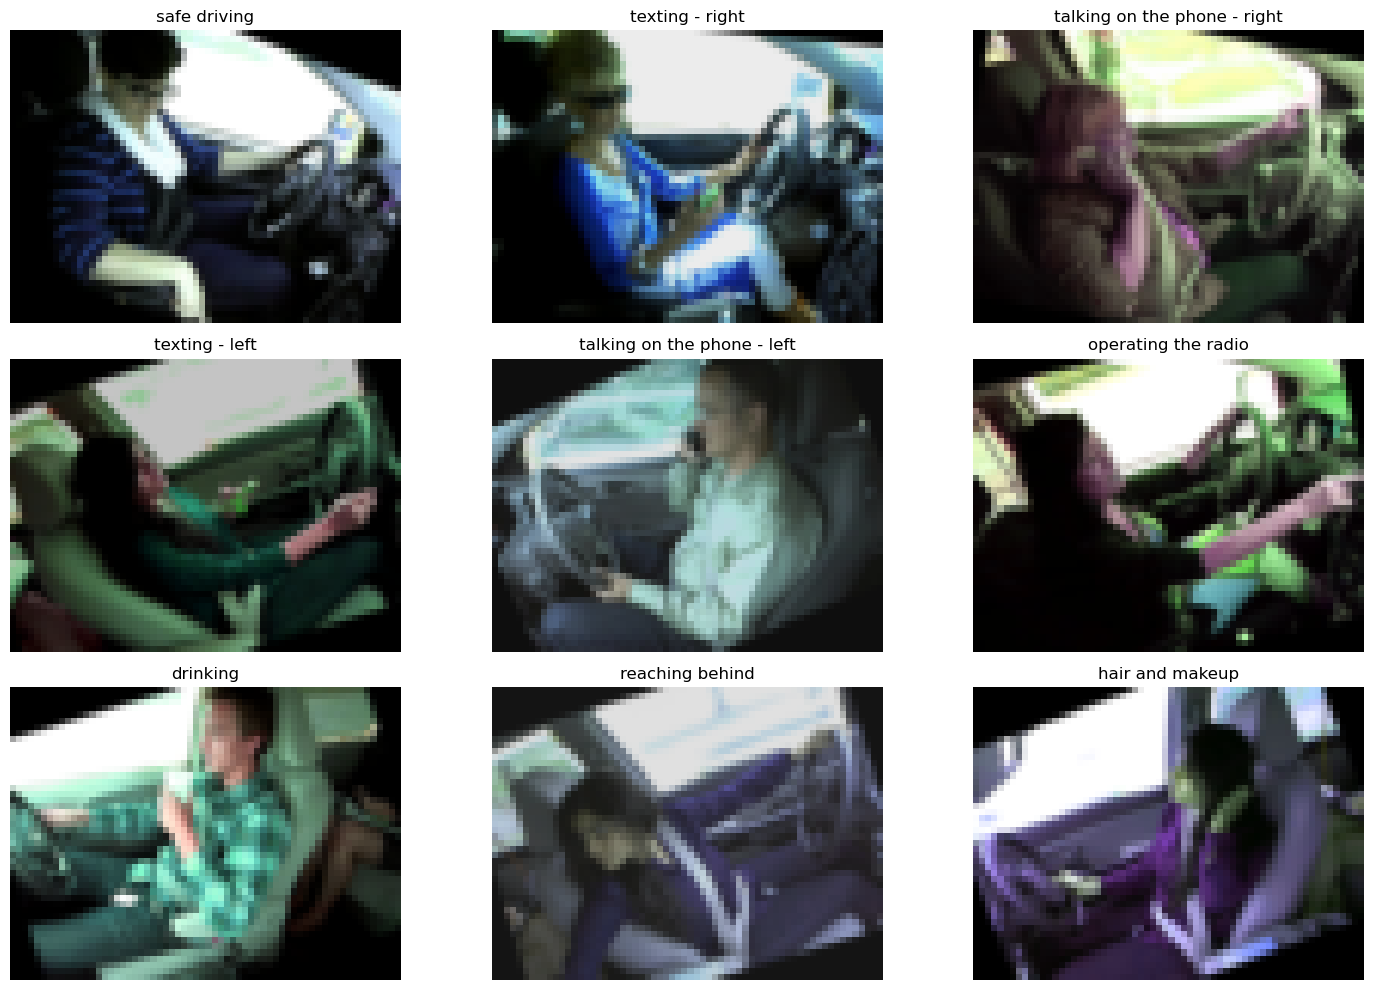

In [26]:
# Displaying val data including transformations
train_data.display_classes(id_to_class=True)

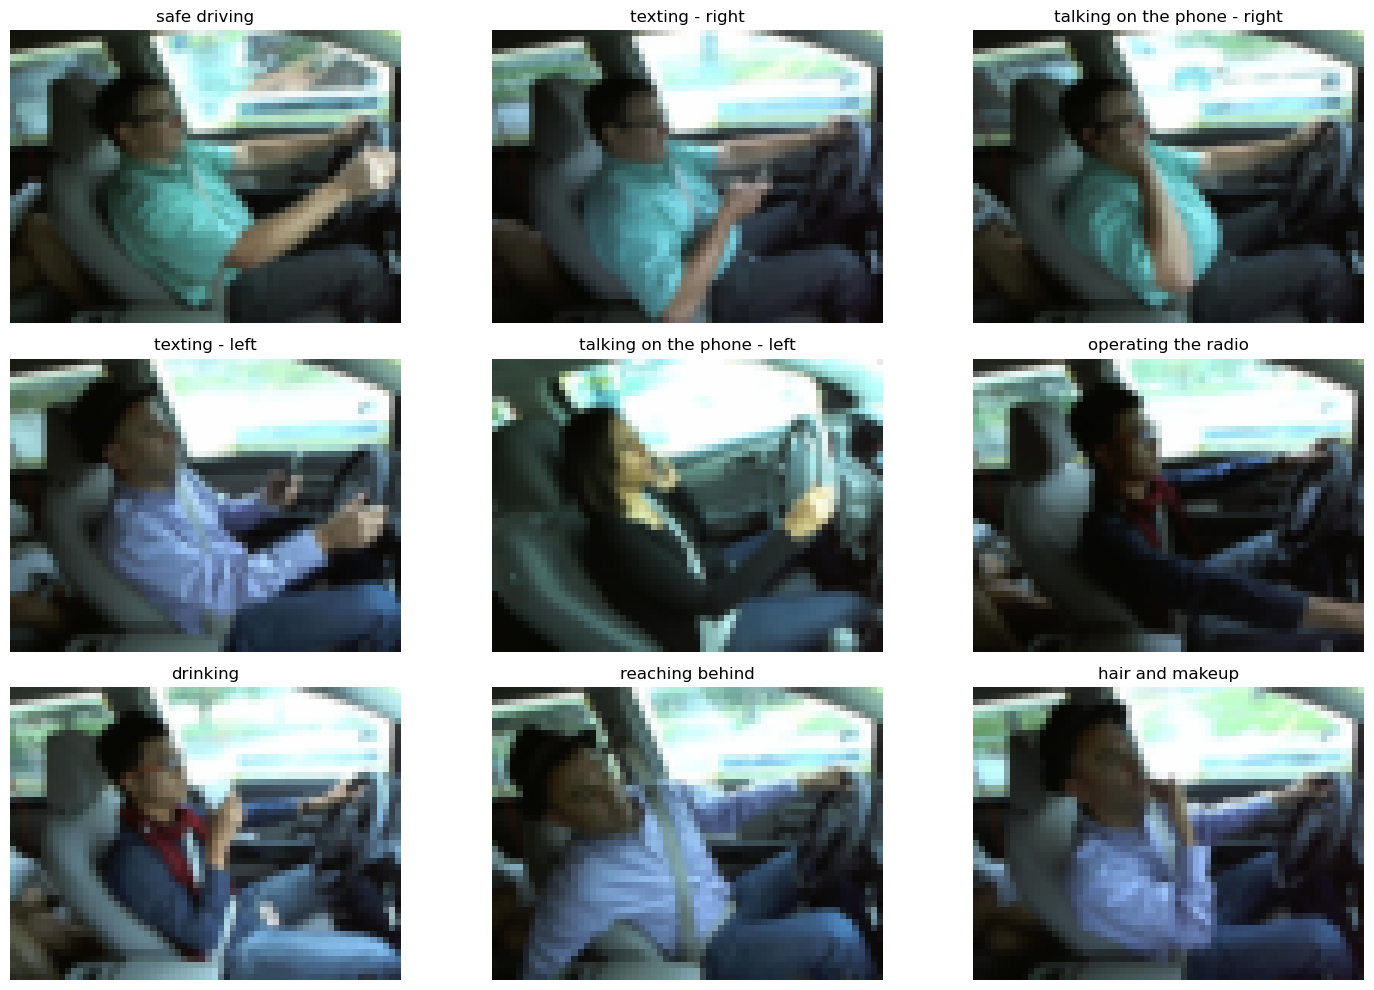

In [28]:
# Displaying val data including transformations
test_data.display_classes(id_to_class=True)

## `Model`

In [9]:
# Convolution block
class ConvBlock(nn.Module):
    def __init__(self, in_channesl, out_channls, kernel_size = 3, stride=1, pool_kernel = 2, dropout_rate = .2, padding=1, skip_last_dropout=False):
        super(ConvBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=in_channesl,
                              out_channels=out_channls,
                              kernel_size=kernel_size,
                              stride=stride,
                              padding=padding),
            nn.SELU(True),
            nn.BatchNorm2d(out_channls),
            nn.Dropout(dropout_rate),
            nn.Conv2d(in_channels=out_channls,
                              out_channels=out_channls,
                              kernel_size=kernel_size,
                              stride=stride,
                              padding=padding),
            nn.SELU(True),
            nn.BatchNorm2d(out_channls),
            nn.MaxPool2d(kernel_size = pool_kernel),
            nn.Dropout(dropout_rate) if not skip_last_dropout else nn.Identity())

    def forward(self, x):
        return self.main(x)

# Fully Connected Dense Block
class Dense(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate):
        super(Dense, self).__init__()
        
        self.main = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=out_features),
            nn.ReLU(True),
            nn.BatchNorm1d(out_features),
            nn.Dropout(dropout_rate),
        )
    
    def forward(self, x):
        return self.main(x)

# Smallest version
class TinyVGG(torch.nn.Module):
    def __init__(self, filters = 32, num_classes = 10, kernel_size = 3,  stride = 1, in_channels = 3, pool_kernel_size = 2, padding=1):
        super(TinyVGG, self).__init__()
        # First Convolution Block
        self.main = nn.Sequential(
            ConvBlock(in_channesl=in_channels, out_channls=filters, kernel_size=kernel_size, stride=stride, pool_kernel=pool_kernel_size, dropout_rate=.25),
            ConvBlock(in_channesl=filters, out_channls=filters*2, kernel_size=kernel_size, stride=stride, pool_kernel=pool_kernel_size, dropout_rate=.3),
            ConvBlock(in_channesl=filters*2, out_channls=filters*2, kernel_size=kernel_size, stride=stride, pool_kernel=pool_kernel_size, dropout_rate=.3),
            nn.Flatten(),   
            Dense(in_features=3072, out_features=128, dropout_rate=.3), # img size L = 52224 # Old small 12288, 3 channels medium sized input images 6144 - Img size L with stride 2 = 26112
            nn.Linear(in_features=128, out_features=num_classes)) # img size L = 52224 # Old small 12288

    def forward(self, x):
        # Pass the data through the convolutional blocks
        x = self.main(x)
        return x

In [10]:
# Smallest version
class VGG_Small(torch.nn.Module):
    def __init__(self, filters = 32, num_classes = 10, kernel_size = 3,  stride = 1, in_channels = 3, pool_kernel_size = 2, padding=1):
        super(VGG_Small, self).__init__()
        # First Convolution Block
        self.main = nn.Sequential(
            ConvBlock(in_channesl=in_channels, out_channls=filters, kernel_size=kernel_size, stride=stride, pool_kernel=pool_kernel_size, dropout_rate=.25),
            ConvBlock(in_channesl=filters, out_channls=filters*2, kernel_size=kernel_size, stride=stride, pool_kernel=pool_kernel_size, dropout_rate=.3),
            ConvBlock(in_channesl=filters*2, out_channls=filters*2, kernel_size=kernel_size, stride=stride, pool_kernel=pool_kernel_size, dropout_rate=.3),
            nn.Flatten(),   
            Dense(in_features=3072, out_features=128, dropout_rate=.3), # img size L = 52224 # Old small 12288, 3 channels medium sized input images 6144 - Img size L with stride 2 = 26112
            nn.Linear(in_features=128, out_features=num_classes)) # img size L = 52224 # Old small 12288

    def forward(self, x):
        # Pass the data through the convolutional blocks
        x = self.main(x)
        return x

In [29]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [30]:
model = VGG_Small(num_classes=10)

# Model summary
x, y = next(iter(train_dataloader))
summary(model, input_size=x.shape)

Layer (type:depth-idx)                   Output Shape              Param #
VGG_Small                                [32, 10]                  --
├─Sequential: 1-1                        [32, 10]                  --
│    └─ConvBlock: 2-1                    [32, 32, 24, 32]          --
│    │    └─Sequential: 3-1              [32, 32, 24, 32]          10,272
│    └─ConvBlock: 2-2                    [32, 64, 12, 16]          --
│    │    └─Sequential: 3-2              [32, 64, 12, 16]          55,680
│    └─ConvBlock: 2-3                    [32, 64, 6, 8]            --
│    │    └─Sequential: 3-3              [32, 64, 6, 8]            74,112
│    └─Flatten: 2-4                      [32, 3072]                --
│    └─Dense: 2-5                        [32, 128]                 --
│    │    └─Sequential: 3-4              [32, 128]                 393,600
│    └─Linear: 2-6                       [32, 10]                  1,290
Total params: 534,954
Trainable params: 534,954
Non-trainable par

## `Training Methods`

##### `Helpers`

In [31]:
def visualize_training(history, num_epochs=50):
    
    # Generate Figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Loss Plots
    sns.lineplot(y=history['train_loss'], x=list(range(len(history['train_loss']))), ax=axs[0], label='Train Loss')
    sns.lineplot(y=history['val_loss'], x=list(range(len(history['val_loss']))), ax=axs[0], label='Validation Loss')
    axs[0].set_ylabel('Cross Entropy Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_xlim(0, num_epochs)

    # Accuracy Plots
    sns.lineplot(y=history['train_acc'], x=list(range(len(history['train_acc']))), ax=axs[1], label='Train Accuracy')
    sns.lineplot(y=history['val_acc'], x=list(range(len(history['val_acc']))), ax=axs[1], label='Validation Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_xlim(0, num_epochs)
    
    # Show plot
    plt.show()

In [32]:
def save_model(model, model_name, epoch):
    """Function for saving model"""
    # Model name, with path
    timestamp = dt.datetime.now().strftime('%Y%m%d_%H%M%S')
    file = f'{model_name}_{timestamp}_epoch_{epoch+1}'
    name = os.path.join(config['outputs']['path'], model_name, file)
    
    # Make directory if not exists
    if not os.path.exists(os.path.join(os.path.join(config['outputs']['path'], model_name))):
        os.makedirs(os.path.join(os.path.join(config['outputs']['path'], model_name)))
    
    # Save model
    torch.save(model.state_dict(), f'{name}.pt')

In [33]:
class EarlyStopper:
    """Early Stopping Class. Copied from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch"""
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            if self.counter != 0:
                print('Early Stopping Counter Reset')
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            print(f'Early Stopping Counter {self.counter} of {self.patience}')
            if self.counter >= self.patience:
                return True
        return False

#### `Train and val step`

In [34]:
def train_step(model, dataloader, loss_fn,optimizer, device):
    """Train step for a single epoch. Taken from PyTorch 'Training with PyTorch'"""
    
    # Losses and accuracies
    train_loss, train_acc = 0, 0

    for i, data in enumerate(dataloader):
        
        # Extracting data and labels + moving to device
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Zero-ing gradients for every new batch
        optimizer.zero_grad()

        # Forward pass
        prediction = model(imgs)
        
        # Computing Loss and Gradient
        loss = loss_fn(prediction, labels)
        loss.backward()

        optimizer.step()

        # Update train loss and accuracy
        train_loss += loss.item()
        train_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return train loss and accuracy
    return train_loss / len(dataloader), train_acc / len(dataloader)


In [35]:
def validation(model, dataloader, loss_fn, device):
    """Validation loop"""
    # Setup validation loss and accuracy
    val_loss, val_acc = 0, 0

    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(dataloader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            imgs, labels  = imgs.to(device), labels.to(device)

            # Forward pass and update validation loss
            prediction = model(imgs)
            loss = loss_fn(prediction, labels)
            val_loss += loss.item()

            # Update validation accuracy
            val_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return validation loss and accuracy
    return val_loss / len(dataloader), val_acc / len(dataloader)

#### `Train loop`

In [40]:
# Training loop for this run. Here we're using the average epochs from the output of the cross validation run over the same 
def train(model, train_dataloader, optimizer, loss_fn, epochs, device):
    """Model training method"""
    # History
    history = dict(train_loss=[],
                   train_acc=[])

    # Save start of training
    total_training_start = time.time()
    # Loop through epochs
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1} of {epochs} started...')
        
        # Get start training step time
        start_train = time.time()
        
        # Set model to train mode and do pass over data - plus save start of training step
        model.train(True)
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)

        # -- SKIP VALIDATION FOR BASED ON CV OUTPUT --
        # model.eval()
        # val_loss, val_acc = validation(model, validation_dataloader, loss_fn, device)
        
        # Calculate total time spent
        end_train = time.time()
        total_m, total_s = divmod(end_train - start_train, 60)
        
        
        print(f"Epoch {epoch+1} of {epochs} ({round(total_m)}:{round(total_s)}) - Train loss: {train_loss:.5f} - Train acc: {train_acc:.5f}")
        
        # Save train and val loss/acc
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
            
    total_training_end = time.time()
    minutes, seconds = divmod(total_training_end-total_training_start, 60)
    
    print(f'Total training time: {round(minutes)}:{round(seconds)}')
    return history

## `Model Training`
Unlike earlier attempts, we've modified this notebook to exclude regularization and training methods such as early stopping, learning rate reduction etc. based on the findings from our cross validation over different splits. This round of training now aims to train the final model based on the average number of epochs found during CV training, based on the assumption that these provide a good proxy between over- and underfitting.

In [42]:
# Setting seed and general training setup
seed = 42

# Setting average seed based on 
epochs = 14
learming_rate = 0.001

# Setting up model
model = VGG_Small(num_classes = 10, in_channels=3)
model = model.to(device)


# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learming_rate) 

results = train(model=model,
                train_dataloader=train_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epochs,
                device=device)


Epoch 1 of 50 started...
Epoch 1 of 50 (8:51) - Train loss: 1.96564 - Train acc: 0.28240

Epoch 2 of 50 started...
Epoch 2 of 50 (8:57) - Train loss: 1.45865 - Train acc: 0.46875

Epoch 3 of 50 started...
Epoch 3 of 50 (10:11) - Train loss: 1.16135 - Train acc: 0.58540

Epoch 4 of 50 started...
Epoch 4 of 50 (9:54) - Train loss: 0.97613 - Train acc: 0.65651

Epoch 5 of 50 started...
Epoch 5 of 50 (10:14) - Train loss: 0.85645 - Train acc: 0.70133

Epoch 6 of 50 started...
Epoch 6 of 50 (8:57) - Train loss: 0.77489 - Train acc: 0.73269

Epoch 7 of 50 started...
Epoch 7 of 50 (8:57) - Train loss: 0.67890 - Train acc: 0.76645

Epoch 8 of 50 started...
Epoch 8 of 50 (8:51) - Train loss: 0.66600 - Train acc: 0.77389

Epoch 9 of 50 started...
Epoch 9 of 50 (8:55) - Train loss: 0.61202 - Train acc: 0.79034

Epoch 10 of 50 started...
Epoch 10 of 50 (9:37) - Train loss: 0.53745 - Train acc: 0.81908

Epoch 11 of 50 started...
Epoch 11 of 50 (9:25) - Train loss: 0.50235 - Train acc: 0.83206

Epo

KeyboardInterrupt: 

In [45]:
# Save model
file = f'TinyVGG_500k_final'
name = os.path.join(config['outputs']['path'], 'TinyVGG_500k', file)
torch.save(model.state_dict(), f'{name}.pt')

### Testing on Test Images

In [82]:
import random
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

test_imgs = os.listdir(config['dataset']['images']['test'])
test_img = test_imgs[random.randint(0, len(test_imgs))]

In [43]:
def test(model, dataloader, device):
    """Test loop"""
    # Setup test accuracy
    test_acc = 0
    
    images = []
    classes = []
    predictions = []
    predictions_argmax = []
    
    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(dataloader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            images.append(imgs), classes.append(labels)
            
            imgs, labels  = imgs.to(device), labels.to(device)

            # Forward pass
            prediction = model(imgs)
            predictions.append(prediction)
            predictions_argmax.append(prediction.argmax(1))

            # Update test accuracy
            test_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return test accuracy
    print(f'Test Accuracy {test_acc / len(dataloader)}')
    return images, classes, predictions, predictions_argmax

In [44]:
test_predictions = test(model=model,
                        dataloader=test_dataloader,
                        device=device)

Test Accuracy 0.7516267128186683


In [60]:
model.load_state_dict(torch.load('/Users/rasmuskrebs/Documents/School/semester_3/advanced_ml/aml_itu/outputs/TinyVGG_200k/TinyVGG_200k_20231201_145303_epoch_12.pt'))

<All keys matched successfully>

In [ ]:
test_images = test_predictions[0]
test_classess = test_predictions[1]
test_predictions = test_predictions[2]
test_predictions_argmax = test_predictions[3]

In [ ]:
test_predictions_argmax[0]

In [ ]:
index = 16
print('Prediction:', config['dataset']['class_mapping']['c' + str(prediction.argmax(1)[index].item())])
print('True:', config['dataset']['class_mapping']['c' + str(labels[index].item())])

plt.imshow(imgs[index].cpu().permute(1, 2, 0))